## General imports

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import torch.nn as nn
import torch
import torch.optim as optim
from scipy.stats import gaussian_kde
from scipy.stats import entropy
from IPython.display import display, HTML

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Creating a toy distribution

In [ ]:
def create_mu(num):
  """Function to create the means of the toy distribution"""
  point_l=[[0,0]]
  for i in range(2,num,2):
    for j in range(2,i+2,2):

      temp_l = [[i,j],[-i,j],[i,-j],[-i,-j]]

      if len(point_l)+4>=num:
        temp_l=temp_l[0:num-len(point_l)]
        point_l.extend(temp_l)
        return point_l

      point_l.extend( temp_l)

  return point_l

def generate_weights(n):
    """Function to create the weights of the toy distribution"""
    result = [1]
    divisor = 2

    for _ in range(n - 1):
        result.extend([1 / divisor] * 4 * (_ % 4))
        divisor *= 2

    return np.array(result[:n])/sum(result[:n])


def sample_GMM(n, pi, mu, sigma):
    """Function to sample from the toy distribution - GMM"""
    K = len(pi)
    simulations = np.zeros((n, mu[0].shape[0]))

    # Generate binomial vector with probability pi
    pi_samples = np.random.multinomial(n, pi, size=1)[0]

    # Assign samples to the simulations array based on the binomial vector
    start = 0
    for k in range(K):
        end = start + pi_samples[k]

        samples = multivariate_normal.rvs(mean=mu[k], cov=sigma[k], size=pi_samples[k])

        if samples.ndim == 1:
                samples = samples.reshape(-1, mu[0].shape[0])

        # Assign samples to simulations
        simulations[start:end, :] = samples

        start = end
    np.random.shuffle(simulations)

    simulations = torch.from_numpy(simulations).to(torch.float32)

    return simulations

Plot Toy distribution

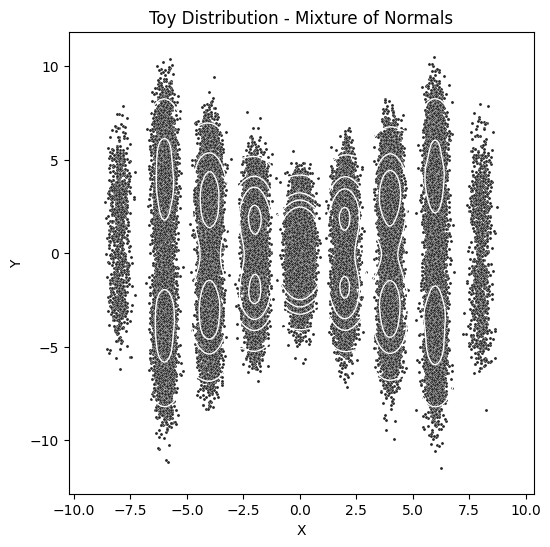

In [ ]:
# Parameters for the toy distribution
n = 100000
num_points = 32
mu = np.array(create_mu(num_points))
pi = np.array(generate_weights(num_points))
cov = [[0.05, 0], [0, 2]]
sigma = np.array([cov for i in range(len(mu))])

# sample
X = sample_GMM(n, pi, mu, sigma)

# Plot
x, y = X[:, 0], X[:, 1]
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

plt.title('Toy Distribution - Mixture of Normals')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Noising Mechanism

Functions that adds noise to a data point, simulating a diffusion process


In [ ]:
class Noiser:
    def __init__(self, baralphas,betas,alphas,phi_start,phi_end,theta_0):
        self.baralphas = baralphas
        self.betas = betas
        self.alphas = alphas
        self.phi_start = phi_start
        self.phi_end = phi_end
        self.theta_0 = theta_0
        self.update_dependent_variables()

    def update_dependent_variables(self):
        # GMM -   see https://arxiv.org/pdf/2106.07582 section 3.2 Mixture of Gaussian Noise
        self.phi_t = self.phi_start + (self.phi_end - self.phi_start) * torch.sqrt(self.baralphas)
        # Gamma - see https://arxiv.org/pdf/2106.07582 section 3.2 Using the Gamma distribution for noise
        self.theta_t = torch.sqrt(self.baralphas) * self.theta_0
        self.k_t = self.betas / (self.alphas * (self.theta_0 ** 2))
        self.bar_k = torch.cumsum(self.k_t, dim=0)

    def update_parameters(self, new_baralphas, new_betas, new_alphas):
        self.baralphas = new_baralphas
        self.betas = new_betas
        self.alphas = new_alphas
        self.update_dependent_variables()

    # see https://arxiv.org/pdf/2006.11239  section 2 Background
    def gussian(self, Xbatch, t):
        eps = torch.randn(size=Xbatch.shape)  # sample noise
        noised = (self.baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + \
                 ((1 - self.baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps
        return noised, eps

    # see https://arxiv.org/pdf/2106.07582 section 3.2 Mixture of Gaussian Noise
    def noise_GMM(self, Xbatch, t):
        # parameters for the noise distribution
        n = Xbatch.shape[0]
        mu = np.array([[0, 0]] * 2)
        sigma = np.array([[[self.phi_t[1], 0], [0, self.phi_t[1]]] for _ in range(len(mu))])

        # sample noise from a mixture of Gaussians
        eps =  sample_GMM(n, [0.5, 0.5], mu, sigma)
        eps = torch.as_tensor(eps, dtype=torch.float) #torch.tensor(eps, dtype=torch.float)

        noised = (self.baralphas[t] ** 0.5).repeat(1, Xbatch.shape[1]) * Xbatch + \
                 ((1 - self.baralphas[t]) ** 0.5).repeat(1, Xbatch.shape[1]) * eps

        return noised, eps

    # see https://arxiv.org/pdf/2106.07582 section 3.2 Using the Gamma distribution for noise
    def gamma_noise(self,Xbatch, t):
      shape = self.bar_k[t].view(-1, 1)
      scale = self.theta_t[t].view(-1, 1)
      shape = shape + 1e-6 # avoid inf

      gamma_distributions = torch.distributions.Gamma(shape[:, None], 1/scale[:, None])
      g_bar = gamma_distributions.sample((2,)).transpose(0, 1).squeeze()

      eps = (g_bar-shape*scale)/torch.sqrt(1-self.baralphas[t])
      noised = torch.sqrt(self.baralphas[t]) * Xbatch + (g_bar - self.bar_k[t] * self.theta_t[t])
      return noised, eps


Test the noising for all the distribution

In [ ]:
def sample_noised_data(noiser, noiselevel):
  """init the noisers for all the distributions"""
  t = torch.full([len(X), 1], fill_value=noiselevel)
  noise_types = {
      "GMM": noiser.noise_GMM,
      "Gaussian": noiser.gussian,
      "Gamma": noiser.gamma_noise
  }
  return t, noise_types


def plot_data_and_noising(noised_data, noiselevel, scheduling_type):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, (name, data) in enumerate(noised_data.items()):
        ax = axs[i]
        ax.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original data")
        ax.scatter(data[:, 0], data[:, 1], marker="*", alpha=0.5, label="Noised data")
        ax.set_title(f"Noised Data ({name})")
        ax.legend()
        ax.set_xlabel("X1")
        ax.set_ylabel("X2")
        ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
        ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

    plt.suptitle(f"Comparison of GMM, Gaussian, and Gamma Noise at Noise Level {noiselevel} - " + scheduling_type + ' Scheduling')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## Diffusion network

In [ ]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(DiffusionModel, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        val = torch.hstack([x, t])  # Add t to inputs
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

## Train functions

In [ ]:
def noised_for_train(Xbatch, timesteps,noiser, noise_type):
  if noise_type=="gussian":
    noised, eps = noiser.gussian(Xbatch, timesteps)
  elif noise_type=="gmm":
    noised, eps = noiser.noise_GMM(Xbatch, timesteps)
  else:
    noised, eps = noiser.gamma_noise(Xbatch, timesteps)
  return noised, eps

# for some reasons some of the gamma noises get inf so we drop them
def filter_infinite_values(Xbatch, timesteps, noised, eps):
  """A function to remove samples that result in infinity during the gamma noising process."""
  valid_indices = ~torch.isinf(eps).any(dim=1) & ~torch.isinf(noised).any(dim=1)
  return Xbatch[valid_indices], timesteps[valid_indices], noised[valid_indices], eps[valid_indices]


def train(model,nepochs,batch_size,noiser, noise_type):
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = optim.lr_scheduler.LinearLR(optimizer,   start_factor=1.0, end_factor=0.01, total_iters=nepochs)

  for epoch in range(nepochs):
      epoch_loss = steps = 0
      for i in range(0, len(X), batch_size):
          Xbatch = X[i:i+batch_size]
          timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
          noised, eps = noised_for_train(Xbatch, timesteps,noiser, noise_type)

          if noise_type=="gamma": # check that all samples are valid (not inf)
            Xbatch, timesteps, noised, eps = filter_infinite_values(Xbatch, timesteps, noised, eps)
            if len(Xbatch) == 0:
                continue

          predicted_noise = model(noised.to(device), timesteps.to(device))
          loss = loss_fn(predicted_noise, eps.to(device))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss
          steps += 1
      if epoch % 10 == 0:
        print(f"Epoch {epoch} loss = {epoch_loss / steps}")



## Sampling functions

In [ ]:
def gaussian_noise_sample(nsamples, nfeatures):
    # see  https://arxiv.org/pdf/2006.11239 3.2 Reverse process and L1:T 1
    return torch.randn(size=(nsamples, nfeatures))

def gmm_noise_sample(nsamples, nfeatures, noiser, t):
    # see https://arxiv.org/pdf/2106.07582 section 3.2 Mixture of Gaussian Noise
    mu = np.array([[0, 0], [0, 0]])
    phi_t = noiser.phi_t
    sigma = np.array([[[phi_t[t], 0], [0, phi_t[t]]] for _ in range(mu.shape[0])])
    return sample_GMM(nsamples, np.array([0.5, 0.5]), mu, sigma)

def gamma_noise_sample(nsamples, nfeatures, noiser, t, init=True):
    # see https://arxiv.org/pdf/2106.07582 section 3.2 Using the Gamma distribution for noise
    t = torch.full([nsamples, 1], fill_value=t)
    shape = noiser.bar_k[t].view(-1, 1)
    scale = noiser.theta_t[t].view(-1, 1)
    shape = shape + 1e-6
    gamma_distributions = torch.distributions.Gamma(shape[:, None], 1/scale[:, None])
    x = gamma_distributions.sample((nfeatures,)).transpose(0, 1).squeeze()
    x = x - shape * scale
    if not init:
        z = x / torch.sqrt(1 - noiser.baralphas[t])
        return z
    return x

def noise_for_sample(nsamples, nfeatures, noiser, noise_type, t, init=True):
    "A function that chooses which function to make noise"
    if noise_type == "gussian":
        return gaussian_noise_sample(nsamples, nfeatures)
    elif noise_type == "gmm":
        return gmm_noise_sample(nsamples, nfeatures, noiser, t)
    elif noise_type == "gamma":
        return gamma_noise_sample(nsamples, nfeatures, noiser, t, init)
    else:
        raise ValueError(f"Unknown noise type: {noise_type}")


def sample_ddpm(model, nsamples, nfeatures,noiser,noise_type, diffusion_steps):
    """Sampler following https://arxiv.org/pdf/2006.11239 - Algorithm 2"""
    with torch.no_grad():
        t=-1
        x= noise_for_sample(nsamples, nfeatures,noiser,noise_type,t).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See https://arxiv.org/pdf/2006.11239  between equations 11 and 12 - this step is the also for GMM and Gamma
            x = 1 / (noiser.alphas[t] ** 0.5) * (x - (1 - noiser.alphas[t]) / ((1-noiser.baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See https://arxiv.org/pdf/2006.11239  section 3.2. - this step is the also for GMM and Gamma
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = noiser.betas[t]
                std = variance ** (0.5)
                z= noise_for_sample(nsamples, nfeatures,noiser,noise_type,t-1).to(device)
                x += std * z
            xt += [x]
        return x, xt

## Generate Data And Compare

In [ ]:
def init_and_train_model(noise_type, device,baralphas,betas,alphas, nfeatures=2, nblocks=4, nepochs=100, batch_size=2048):
  """A function to initialize and train the model for GMM, Gamma, or Gaussian based on the `noise_type` parameter,
  and also configure the scheduling using `baralphas`, `betas`, and `alphas`."""
  model = DiffusionModel(nfeatures=nfeatures, nblocks=nblocks).to(device)
  noiser = Noiser(baralphas,betas,alphas,phi_start,phi_end,theta_0)
  print(f"\nTraining {noise_type.capitalize()} Model:")
  train(model, nepochs, batch_size,noiser, noise_type)
  return model

def initialize_and_train_models(noise_types_lst, device, baralphas, betas, alphas):
  """train model for all the distribution"""
  models = {}
  for noise_type in noise_types_lst:
      models[noise_type] = init_and_train_model(noise_type, device,baralphas,betas,alphas)

  # Access trained models
  model_gussian = models["gussian"]
  model_gmm = models["gmm"]
  model_gamma = models["gamma"]

  print("All models have been initialized and trained.")
  return model_gussian, model_gmm, model_gamma


In [ ]:
def generate_new_data_from_models(model_gmm, model_gussian, model_gamma, noiser, diffusion_steps, plot=True, scheduling_type='Cosine'):
  """function to generate data from all the models and plot them side by side"""
  models = {
      "GMM": (model_gmm, "gmm"),
      "Gaussian": (model_gussian, "gussian"),
      "Gamma": (model_gamma, "gamma")
  }

  generated_data = {}
  for name, (model, noise_type) in models.items():
      # generate new data from the model
      Xgen, _ = sample_ddpm(model,  5000, 2,noiser, noise_type=noise_type, diffusion_steps=diffusion_steps)
      generated_data[name] = Xgen.cpu()

  if plot:
      # Plot side by side
      fig, axs = plt.subplots(1, 3, figsize=(18, 6))

      for i, (name, data) in enumerate(generated_data.items()):
          ax = axs[i]
          ax.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original data")
          ax.scatter(data[:, 0], data[:, 1], marker="1", alpha=0.5, label=f"Generated data - {name}")
          ax.set_title(f"Original vs. Generated Data - {name}")
          ax.legend()
          ax.set_xlabel("X1")
          ax.set_ylabel("X2")
          ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
          ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)

      plt.suptitle("Comparison of Generated Data: Gaussian vs. GMM vs. Gamma - " + scheduling_type)
      plt.tight_layout(rect=[0, 0, 1, 0.95])

      plt.show()
  return generated_data


## Comparison of different scheduling methods

For reallization - a visualization of 1000 diffusion steps.

In our comperative analysis we will use 40 diffusion steps (computational costs).

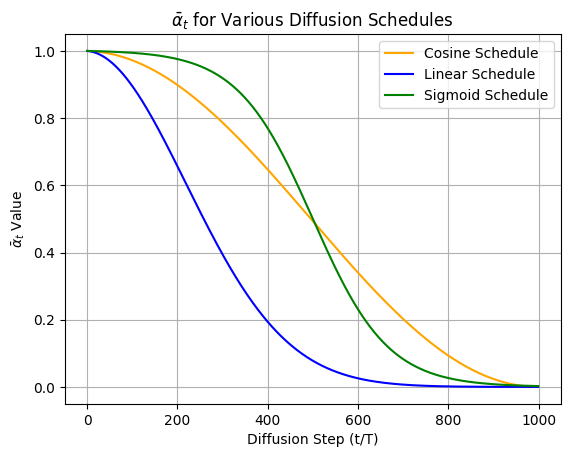

In [ ]:
# Diffusion steps
diffusion_steps = 1000  # Use 1000 as in the OpenAI figure

# Cosine Schedule
def cosine_schedule(diffusion_steps):
    s = 0.008
    timesteps = torch.linspace(0, 1, diffusion_steps)
    f_t = torch.cos((timesteps + s) / (1 + s) * np.pi / 2) ** 2
    baralphas = f_t / f_t[0]  # Normalized to start at 1
    betas = 1 - baralphas / torch.cat([baralphas[0:1], baralphas[:-1]])
    alphas = 1 - betas
    return alphas, baralphas, betas

# Linear Schedule (OpenAI-style)
def linear_schedule(diffusion_steps, beta_start=0.0001, beta_end=0.02):
    betas = torch.linspace(beta_start, beta_end, diffusion_steps)
    alphas = 1 - betas
    baralphas = torch.cumprod(alphas, dim=0)  # Cumulative product
    return alphas, baralphas, betas

# Sigmoid Schedule
def sigmoid_schedule(diffusion_steps):
    t = torch.linspace(0, 1, diffusion_steps)
    f_t = 1 / (1 + torch.exp((t - 0.5) * 12))  # Sigmoid curve
    baralphas = f_t / f_t[0]  # Normalize to start at 1
    betas = 1 - baralphas / torch.cat([baralphas[0:1], baralphas[:-1]])
    alphas = 1 - betas
    return alphas, baralphas, betas

# Cosine \bar{\alpha}_t
cosine_alphas, cosine_baralphas, cosine_betas = cosine_schedule(diffusion_steps)
plt.plot(cosine_baralphas.numpy(), label="Cosine Schedule", color='orange')

# Linear \bar{\alpha}_t
linear_alphas, linear_baralphas, linear_betas = linear_schedule(diffusion_steps)
plt.plot(linear_baralphas.numpy(), label="Linear Schedule", color='blue')

# Sigmoid \bar{\alpha}_t
sigmoid_alphas, sigmoid_baralphas, sigmoid_betas = sigmoid_schedule(diffusion_steps)
plt.plot(sigmoid_baralphas.numpy(), label="Sigmoid Schedule", color='green')

plt.title(r"$\bar{\alpha}_t$ for Various Diffusion Schedules")
plt.xlabel("Diffusion Step (t/T)")
plt.ylabel(r"$\bar{\alpha}_t$ Value")
plt.legend()
plt.grid(True)
plt.show()


As we can see, the sigmoid approach preserves the overall concept of the cosine method, slowing down the denoising process in the hopes of generating better data.

## Test different scheduling methods

Functions that construct the betas for various types of noising scheduling.

In [ ]:
# Cosine Schedule
def cosine_schedule(diffusion_steps):
    ## from https://arxiv.org/pdf/2102.09672 section 3.2. Improving the Noise Schedule
    s = 0.008
    timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
    f_t = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2
    baralphas = f_t / f_t[0]  # Normalized to start at 1
    betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
    alphas = 1 - betas
    return alphas, baralphas, betas

# Sigmoid Schedule
def sigmoid_schedule(diffusion_steps, scale_factor=10, shift_value=0.05):
    t = torch.linspace(0, 1, diffusion_steps)
    f_t = 1 / (1 + torch.exp((t - 0.5) * scale_factor))  # Sigmoid curve

    # Adjust f_t with shift to prevent negative betas
    f_t = (f_t - f_t.min()) / (f_t.max() - f_t.min()) + shift_value

    # Compute betas and alphas
    baralphas = f_t / f_t[0]  # Normalize to start at 1
    betas = 1 - baralphas / torch.cat([baralphas[0:1], baralphas[:-1]])
    alphas = 1 - betas

    return alphas, baralphas, betas


### Hyperparameters

Hyperparameters for the different types of nosing

In [ ]:
# Diffusion steps
diffusion_steps = 40

## from https://arxiv.org/pdf/2106.07582   section 4 Experiments
# GMM hyper
phi_start, phi_end=1, 0.5

# Gamma hyper
theta_0 = 0.001

# Cosine \bar{\alpha}_t
cosine_alphas, cosine_baralphas, cosine_betas = cosine_schedule(diffusion_steps)

# Sigmoid \bar{\alpha}_t
sigmoid_alphas, sigmoid_baralphas, sigmoid_betas = sigmoid_schedule(diffusion_steps)

### Cosine

Adding noise based on a cosine scheduling function

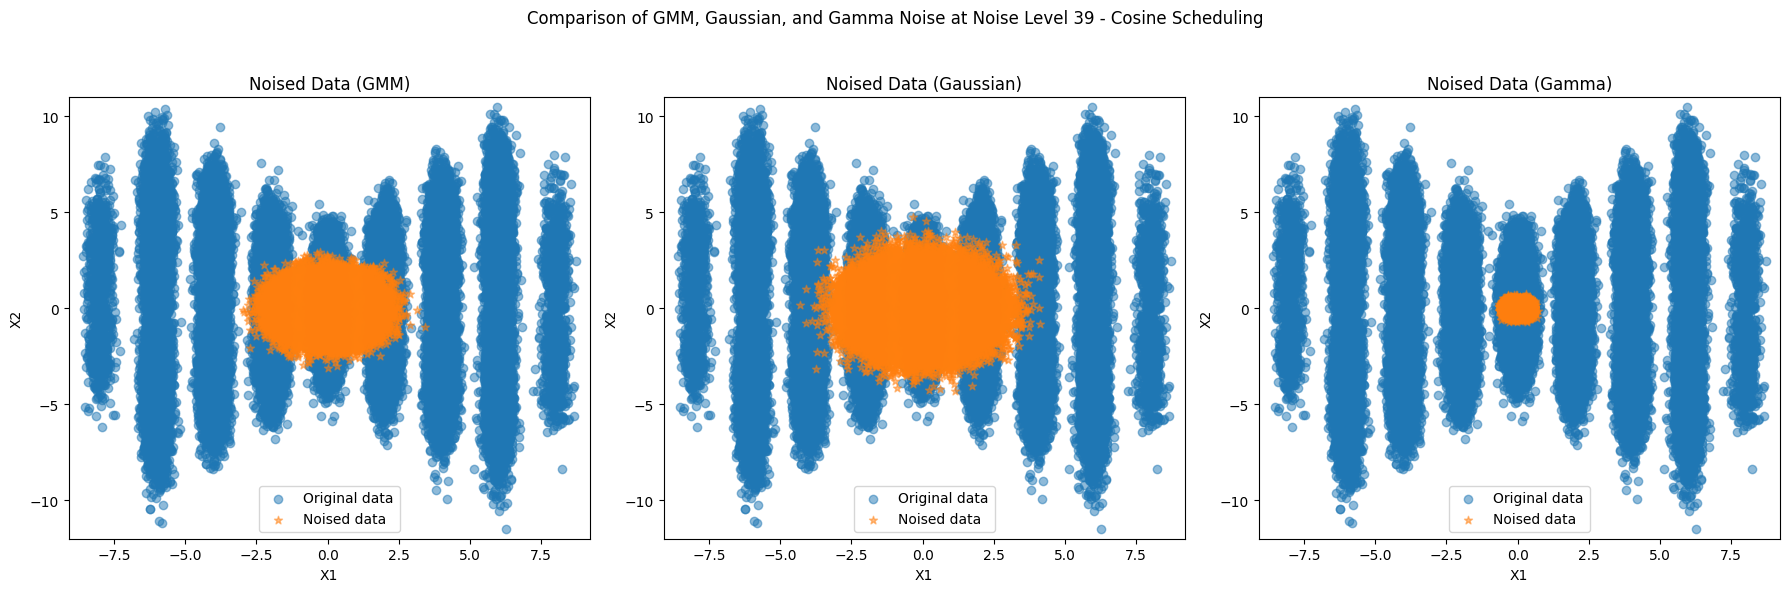

In [ ]:
noiselevel = 39 # the final noise step of the forward process - X_T
cosine_noiser = Noiser(cosine_baralphas,cosine_betas,cosine_alphas,phi_start,phi_end,theta_0) # init the noiser

t, noise_types = sample_noised_data(noiser=cosine_noiser, noiselevel=noiselevel)

cosine_noised_data = {name: func(X, t)[0] for name, func in noise_types.items()}

plot_data_and_noising(noised_data=cosine_noised_data, noiselevel=noiselevel, scheduling_type='Cosine')

As observed, we can noise the data in a single step according to the algorithm. It is interesting to note the differences between the normal distribution and the GMM when the normal distribution has a higher variance. In contrast, the gamma distribution exhibits much smaller variance, and it appears that the distribution is not isotropic compared to the normal distribution.

Train the diffusion model for all the distributions

In [ ]:
# Initialize and train models
noise_types_lst = ["gussian", "gmm", "gamma"]

cosine_model_gussian, cosine_model_gmm, cosine_model_gamma = initialize_and_train_models(
    noise_types_lst=noise_types_lst, device=device,baralphas=cosine_baralphas,betas=cosine_betas,alphas=cosine_alphas)


Training Gussian Model:
Epoch 0 loss = 0.9033104777336121
Epoch 10 loss = 0.7567911744117737
Epoch 20 loss = 0.736961305141449
Epoch 30 loss = 0.7299433946609497
Epoch 40 loss = 0.720940113067627
Epoch 50 loss = 0.7211293578147888
Epoch 60 loss = 0.7129697799682617
Epoch 70 loss = 0.713770866394043
Epoch 80 loss = 0.7050297856330872
Epoch 90 loss = 0.7022196054458618

Training Gmm Model:
Epoch 0 loss = 0.46029582619667053
Epoch 10 loss = 0.40815243124961853
Epoch 20 loss = 0.39862260222435
Epoch 30 loss = 0.3890886604785919
Epoch 40 loss = 0.3856056332588196
Epoch 50 loss = 0.38549578189849854
Epoch 60 loss = 0.3841991126537323
Epoch 70 loss = 0.37857046723365784
Epoch 80 loss = 0.37079110741615295
Epoch 90 loss = 0.37271714210510254

Training Gamma Model:
Epoch 0 loss = 0.5994668006896973
Epoch 10 loss = 0.5637063980102539
Epoch 20 loss = 0.5518107414245605
Epoch 30 loss = 0.542140781879425
Epoch 40 loss = 0.5432538390159607
Epoch 50 loss = 0.5366610288619995
Epoch 60 loss = 0.536666

Plot of the results in each of the distributions according to the cosine schedule

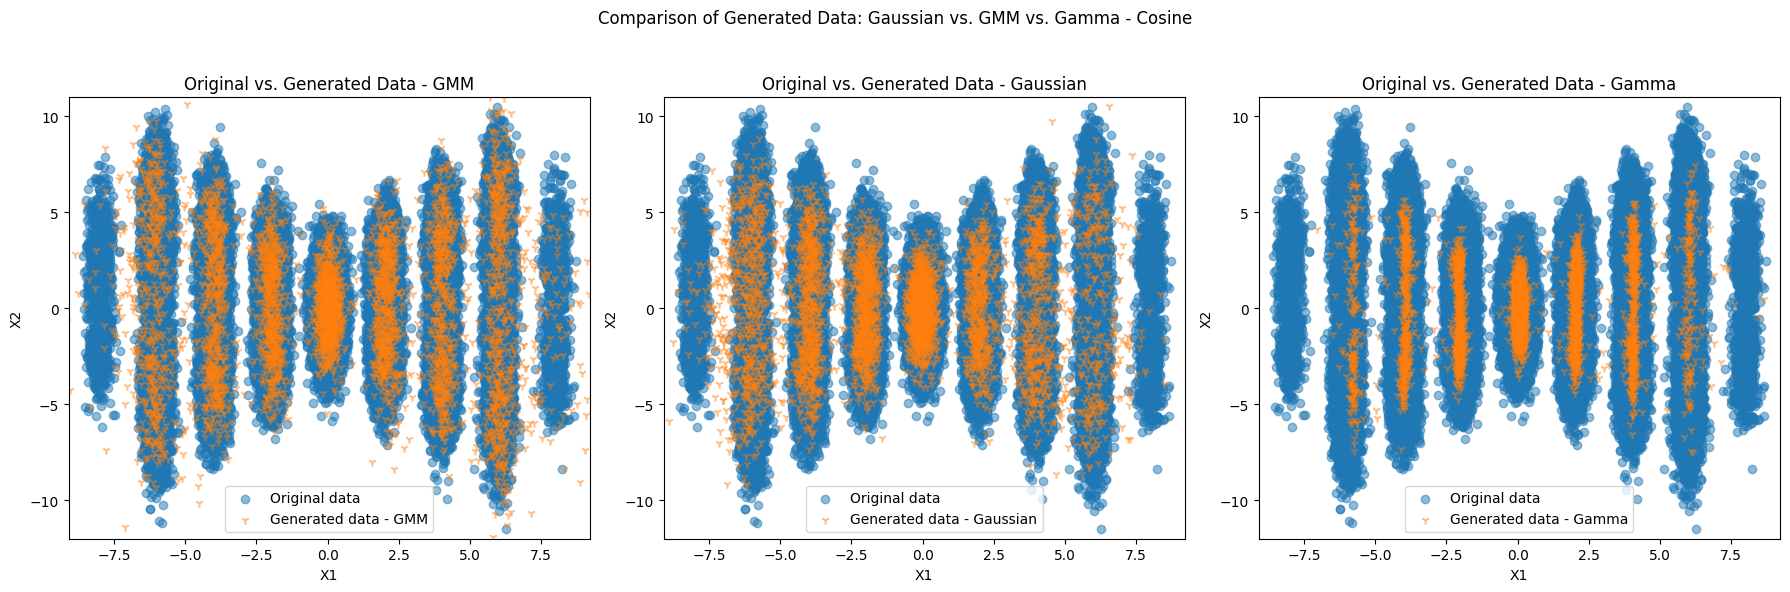

In [ ]:
cosine_generated_data = generate_new_data_from_models(model_gmm=cosine_model_gmm,
                                                      model_gussian=cosine_model_gussian, model_gamma=cosine_model_gamma,
                                                      noiser=cosine_noiser, diffusion_steps=diffusion_steps, scheduling_type='Cosine')

As can be seen in the graph, there is a notable similarity between the Gaussian and GMM distributions, although the Gaussian distribution tends to spread more within the distribution, which is the desired outcome. In contrast, the gamma distribution is more concentrated with lower variance in each section, which is less ideal because it suggests that some parts of the distribution are not being sampled effectively.

### Sigmoid

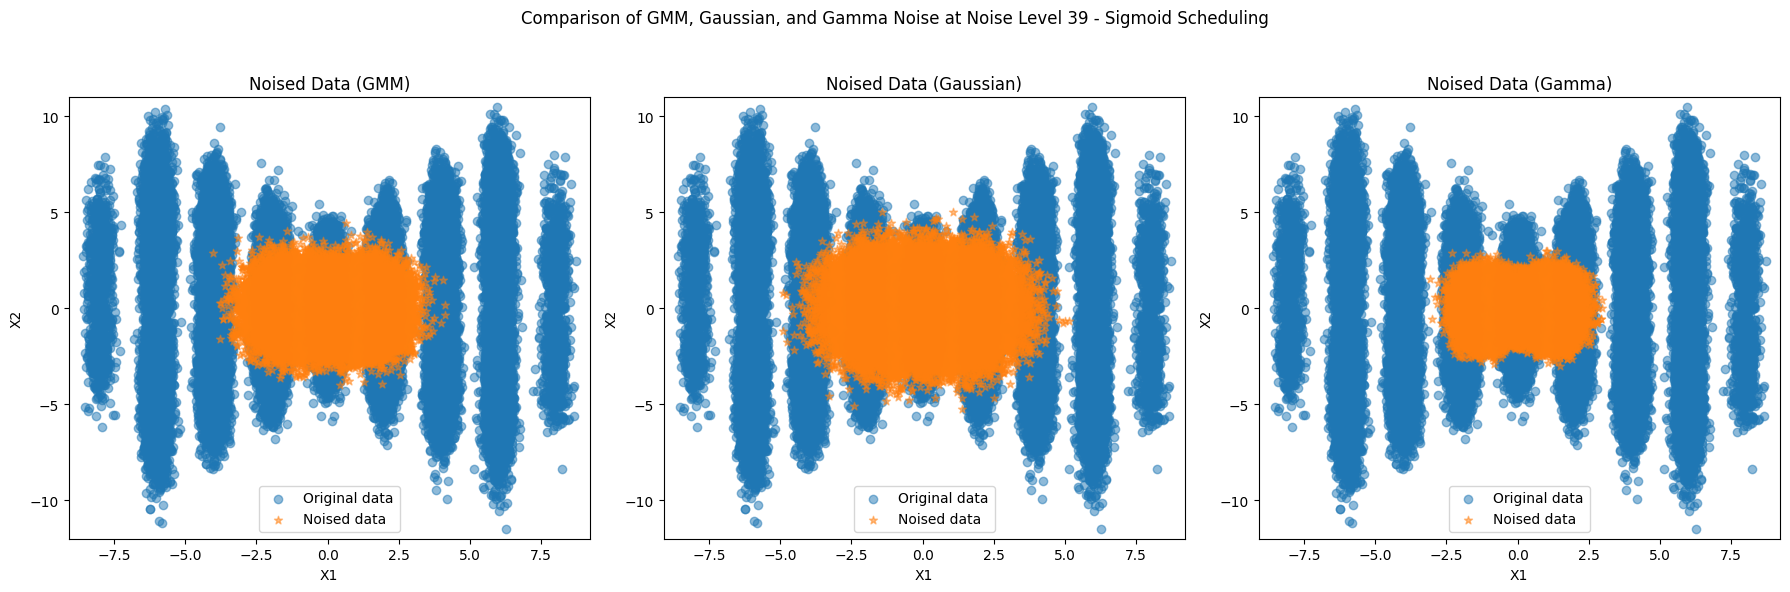

In [ ]:
noiselevel = 39 # the final noise step of the forward process - X_T
sigmoid_noiser = Noiser(sigmoid_baralphas,sigmoid_betas,sigmoid_alphas,phi_start,phi_end,theta_0) # init the noiser

t, noise_types = sample_noised_data(noiser=sigmoid_noiser, noiselevel=noiselevel)

sigmoid_noised_data = {name: func(X, t)[0] for name, func in noise_types.items()}

plot_data_and_noising(noised_data=sigmoid_noised_data, noiselevel=noiselevel, scheduling_type='Sigmoid')

It can be observed that using the sigmoid function after 39 steps has less noise in the data. This is not surprising  as demonstrated by the graph showing noise levels across different schedules.

In [ ]:
# Initialize and train models
noise_types_lst = ["gussian", "gmm", "gamma"]

sigmoid_model_gussian, sigmoid_model_gmm, sigmoid_model_gamma = initialize_and_train_models(
    noise_types_lst=noise_types_lst,
    device=device,
    baralphas=sigmoid_baralphas,
    betas=sigmoid_betas,
    alphas=sigmoid_alphas)


Training Gussian Model:
Epoch 0 loss = 0.9047669172286987
Epoch 10 loss = 0.7741665244102478
Epoch 20 loss = 0.7572818398475647
Epoch 30 loss = 0.7523679137229919
Epoch 40 loss = 0.7441665530204773
Epoch 50 loss = 0.7363556027412415
Epoch 60 loss = 0.729736328125
Epoch 70 loss = 0.7259098887443542
Epoch 80 loss = 0.7166765332221985
Epoch 90 loss = 0.7208312153816223

Training Gmm Model:
Epoch 0 loss = 0.4636673331260681
Epoch 10 loss = 0.4216380715370178
Epoch 20 loss = 0.41174668073654175
Epoch 30 loss = 0.4076579213142395
Epoch 40 loss = 0.4056802988052368
Epoch 50 loss = 0.400042325258255
Epoch 60 loss = 0.3976895213127136
Epoch 70 loss = 0.3967677652835846
Epoch 80 loss = 0.39319416880607605
Epoch 90 loss = 0.39175570011138916

Training Gamma Model:
Epoch 0 loss = 0.6199809908866882
Epoch 10 loss = 0.577610433101654
Epoch 20 loss = 0.5689665675163269
Epoch 30 loss = 0.5677412152290344
Epoch 40 loss = 0.5563012957572937
Epoch 50 loss = 0.5539755821228027
Epoch 60 loss = 0.539536714

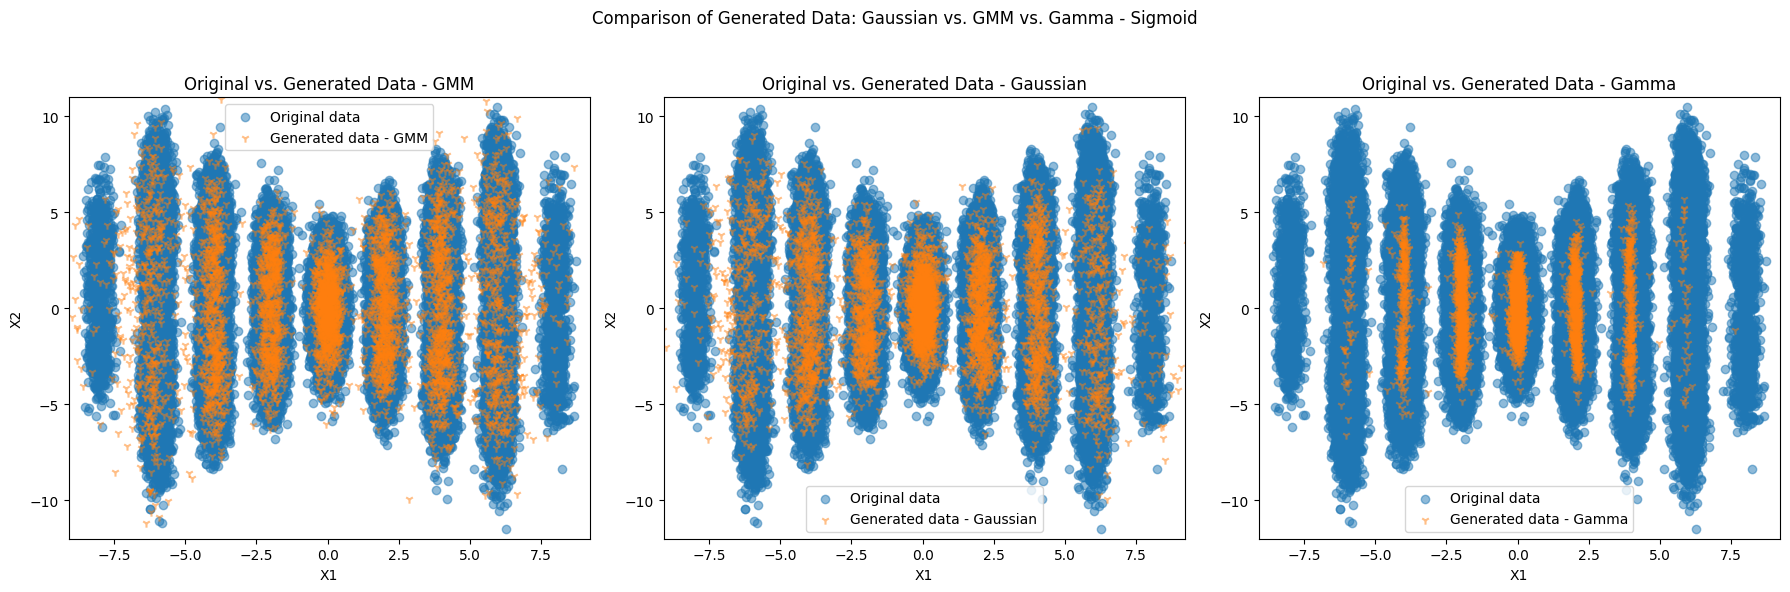

In [ ]:
sigmoid_generated_data = generate_new_data_from_models(model_gmm=sigmoid_model_gmm,
                                                      model_gussian=sigmoid_model_gussian, model_gamma=sigmoid_model_gamma,
                                                      noiser=sigmoid_noiser, diffusion_steps=diffusion_steps, scheduling_type='Sigmoid')

As observed, the sigmoid schedule does not appear to improve the GMM, and even in the Gamma distribution, there is still very low dispersion in each section. The Gaussian distribution performs well. We will proceed to evaluate the accelerations with a more quantitative approach rather than relying solely on visual inspection.

## Evaluation - KL Divergence

Functions for calculating KL divergence.

In [ ]:
# KDE function to estimate density
def compute_kde(data, bandwidth='scott'):
    kde = gaussian_kde(data.T.cpu().numpy(), bw_method=bandwidth)  # Data should be transposed for gaussian_kde
    return kde

# Function to compute the KL divergence between two KDEs
def kl_divergence_kde(kde_p, kde_q, samples, eps=1e-8):
    p_density = kde_p(samples.cpu().numpy()) + eps  # Avoid division by zero
    q_density = kde_q(samples.cpu().numpy()) + eps  # Avoid division by zero
    return entropy(p_density, q_density)

# Assuming each generated data is a dictionary with 'GMM', 'Gaussian', and 'Gamma' keys
generated_data_dicts = {
    'Cosine': cosine_generated_data,
    'Sigmoid': sigmoid_generated_data,
}

# KDE of the original MoG data
original_data = X  # Assuming X is already a tensor
kde_original = compute_kde(original_data)


Checking the distance on the distributions and the different schedule methods

In [ ]:
results = []

# Create a 2D grid of samples for KDE evaluation, matching the original data's dimensions
grid_x, grid_y = torch.meshgrid(
    torch.linspace(torch.min(original_data[:, 0]), torch.max(original_data[:, 0]), 100),
    torch.linspace(torch.min(original_data[:, 1]), torch.max(original_data[:, 1]), 100),
     indexing='ij')
grid_samples = torch.vstack([grid_x.ravel(), grid_y.ravel()])

# Iterate over each generated dataset (Cosine, Sigmoid, etc.)
for name, gen_data_dict in generated_data_dicts.items():
    for data_type, data in gen_data_dict.items():
        # Compute KDE of the generated data
        kde_generated = compute_kde(data)

        # Compute KL divergence between the original and generated KDEs
        kl_div = kl_divergence_kde(kde_original, kde_generated, grid_samples)

        # Append the results as a dictionary
        results.append({
            'Scheduling Method': name,
            'Limit Distribution': data_type,
            'KL Divergence': kl_div
        })

df_results = pd.DataFrame(results)

# Display the DataFrame with HTML title
html_title = "<h2>KL Divergence of Generated Data for Each Type</h2>"
df_html = html_title + df_results.to_html(index=False)
display(HTML(df_html))

Scheduling Method,Limit Distribution,KL Divergence
Cosine,GMM,0.122613
Cosine,Gaussian,0.076514
Cosine,Gamma,0.285620
Sigmoid,GMM,0.083051
Sigmoid,Gaussian,0.073312
Sigmoid,Gamma,0.899904


As we can see, the Gaussian results are the best, and using the sigmoid function further improves these results.

# Dynamic Scheduler

## Algorithm

A dynamic method for updating the beta throughout the training process.


**Algorithm 1: Dynamic Noise Scheduling for Diffusion Model Training**

**Input:**
- Model $M$
- Dataset $D$
- Number of diffusion steps $T$
- Number of epochs $E$
- Batch size $B$
-  Noiser - funciton that Noise the data $N$
- Number Of $\beta$ changed in each epoch $K$
- Restore interval $L$
- Weight for updating betas $S$

**Output:**
- Trained model $M$

1. $\beta_0, \alpha_0, \bar{\alpha}_0$ ← Noiser.initialize_parameters()
2. For $e = 1$ to $E$ do:
    1. $L$ ← [0,...,0] – number of diffusion steps
    2. For each batch $X$ in $D$ do:
        1. $t$ ← sample_timesteps from uniform(1, $T$)
        2. $X_{\text{noisy}}, \epsilon$ ← Noiser.add_noise($X$, $t$)
        3. $\epsilon_{\text{pred}}$ ← $M(X_{\text{noisy}}, t)$ – using the NN
        4. $L$ += compute_stage_losses($\epsilon_{\text{pred}}, \epsilon, t$)
        5. Update NN parameters ($M$, loss($\epsilon_{\text{pred}}, \epsilon$))
    3. End For
    4. If $e \% L == 0$:
        1. Noiser.update_diffusion_parameters ($\beta_0, \alpha_0, \bar{\alpha}_0$)
    5. $\beta_{\text{new}},\space{} \alpha_{\text{new}}, \space{} \bar{\alpha}_{\text{new}}$ ← update_diffusion_parameters($L, N.\beta, N.\alpha, N.\bar{\alpha}, K$)
    6. Noiser.update_diffusion_parameters ($\beta_{\text{new}}, \alpha_{\text{new}}, \bar{\alpha}_{\text{new}}$)
3. End For
4. Return $M$

**Function update_diffusion_parameters(L, \beta, \alpha, \bar{\alpha}, K):**

1. $I$ ← indices of $K$ highest values in $L[1:-1]$
2. $\beta_{\text{new}}$ ← $\beta$.copy()
3. For $i$ in $I$ do:
    1. $\beta_{\text{new}}[i]$ ← $(S \cdot \beta[i] + (1-S) \cdot \beta[i+1])$
4. End For
5. $\alpha_{\text{new}}$ ← $1 - \beta_{\text{new}}$
6. $\bar{\alpha}_{\text{new}}$ ← cumprod($\alpha_{\text{new}}$)
7. Return $\beta_{\text{new}}, \alpha_{\text{new}}, \bar{\alpha}_{\text{new}}$


## Train functions

Functions to handle the beta update process during training

In [ ]:
def calculate_stage_losses(predicted_noise, eps, timesteps):
    # Ensure all inputs are on the same device
    device = predicted_noise.device
    eps = eps.to(device)
    timesteps = timesteps.to(device)
    timesteps = timesteps.squeeze()

    # Step 1 & 2: Subtract and square
    squared_diff = ((predicted_noise - eps) ** 2).sum(axis=1)

    # Step 3: Sum for each timestep
    num_timesteps = timesteps.max().item() + 1
    stage_losses = torch.zeros(num_timesteps, device=device)

    for t in range(num_timesteps):
        mask = (timesteps == t)
        stage_losses[t] = squared_diff[mask].sum()

    return stage_losses

def update_diffusion_parameters(stage_losses, betas, alphas, baralphas,S=1/3, k=7):
    device = stage_losses.device
    num_steps = len(stage_losses)

    # Find indices of k highest losses, excluding first and last
    _, top_k_indices = torch.topk(stage_losses[1:-1], k)
    top_k_indices += 1  # Shift indices by 1 to account for excluded first element

    # Create a copy of betas to modify
    new_betas = betas.clone()
    for idx in top_k_indices:
        # Update beta to be the mean of beta_t and beta_{t-1}
        new_betas[idx] = ( S * betas[idx] +S * betas[idx+1])

    # Recalculate alphas and baralphas
    new_alphas = 1 - new_betas
    new_baralphas = torch.cumprod(new_alphas, dim=0)

    return new_betas, new_alphas, new_baralphas

def update_betas_flow(epoch, E, noiser, init_baralphas, init_beta, init_alphas, epoch_stage_losses):
    if epoch % E == 0:
        noiser.update_parameters(init_baralphas, init_beta, init_alphas)

    new_betas, new_alphas, new_baralphas = update_diffusion_parameters(
        epoch_stage_losses,
        noiser.betas,
        noiser.alphas,
        noiser.baralphas,
        k=2)
    noiser.update_parameters(new_baralphas, new_betas, new_alphas)

An updated version of the train function that uses a dynamic update of the betas

In [ ]:
def train(model,nepochs,batch_size,noiser, noise_type,L=5):
  init_beta,init_alphas,init_baralphas = noiser.betas, noiser.alphas, noiser.baralphas

  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  scheduler = optim.lr_scheduler.LinearLR(optimizer,   start_factor=1.0, end_factor=0.01, total_iters=nepochs)
  all_epoch_stage_losses = torch.zeros((nepochs // 10 + 1, diffusion_steps), device='cpu')

  for epoch in range(1,nepochs+1):
      epoch_loss = steps = 0
      epoch_stage_losses= torch.zeros(diffusion_steps, device=device)

      for i in range(0, len(X), batch_size):
          Xbatch = X[i:i+batch_size]
          timesteps = torch.randint(0, diffusion_steps, size=[len(Xbatch), 1])
          noised, eps = noiser.gussian(Xbatch, timesteps)
          predicted_noise = model(noised.to(device), timesteps.to(device))
          loss = loss_fn(predicted_noise, eps.to(device))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          epoch_loss += loss
          steps += 1

          # calcualte and update the loss for each stage for the losses plot
          temp_stage_losses= calculate_stage_losses(predicted_noise, eps, timesteps)
          epoch_stage_losses += temp_stage_losses

      if epoch % 10 == 0:
        print(f"Epoch {epoch} loss = {epoch_loss / steps}")

      # add the losses to plot them over the T
      if epoch==1 or epoch % 10 == 0:
        all_epoch_stage_losses[epoch // 10] = epoch_stage_losses.cpu().detach()

      # update the betas after checking the worst losses for each stage
      update_betas_flow(epoch, L, noiser, init_baralphas, init_beta, init_alphas, epoch_stage_losses)

  return model ,all_epoch_stage_losses

The function displaying the loss across different steps and epochs provides insight into why, during dynamic updates, we aim to adjust beta towards $\beta_{t+1}$. This approach seeks to optimize the progression of the diffusion process.

In [ ]:
def plot_stage_losses_by_step_with_colorbar(all_losses, diffusion_steps):
    fig, ax = plt.subplots()

    # Generate a colormap with as many colors as diffusion steps
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(vmin=0, vmax=diffusion_steps - 1)

    # Plot each line with a color from the colormap
    for t in range(diffusion_steps):
        ax.plot(range(all_losses.shape[0]), all_losses[:, t], color=cmap(norm(t)))

    # Modify x-axis ticks and labels
    x_ticks = range(0, all_losses.shape[0], 2)  # Every 2nd tick
    x_labels = [str(x * 10) for x in x_ticks]  # Multiply by 10
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Stage Losses Across Diffusion Steps')

    # Add a colorbar to indicate which color corresponds to which diffusion step (t)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed to create the colorbar
    cbar = fig.colorbar(sm, ax=ax, ticks=np.linspace(0, diffusion_steps - 1, num=5))
    cbar.set_label('Diffusion Step (t)')

    plt.tight_layout()
    plt.show()

Training according to the method of the dynamic schedule

In [ ]:
models_dynamic = DiffusionModel(nfeatures=2, nblocks=4).to(device)
noiser = Noiser(cosine_baralphas,cosine_betas,cosine_alphas,phi_start,phi_end,theta_0)
models_dynamic, all_epoch_stage_losses = train(models_dynamic, nepochs=100, batch_size=2048 ,noiser=noiser, noise_type="gussian")

Epoch 10 loss = 0.7580209970474243
Epoch 20 loss = 0.7371634840965271
Epoch 30 loss = 0.7270486950874329
Epoch 40 loss = 0.7184557914733887
Epoch 50 loss = 0.7168607711791992
Epoch 60 loss = 0.7103272080421448
Epoch 70 loss = 0.7035504579544067
Epoch 80 loss = 0.7035914063453674
Epoch 90 loss = 0.7022473812103271
Epoch 100 loss = 0.7020324468612671


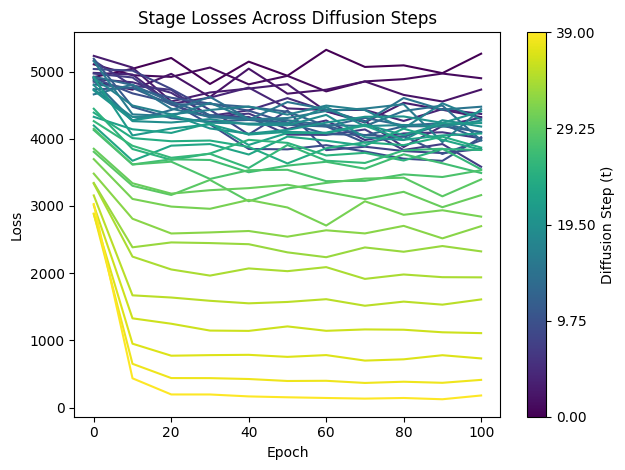

In [ ]:
plot_stage_losses_by_step_with_colorbar(all_epoch_stage_losses, diffusion_steps)

As observed, the loss consistently decreases across the epochs, with a noticeable trend of smaller loss values as we progress through the steps (T). For example, the loss at step T=1 is significantly higher than at step T=30. To further optimize the model's performance, we aim to adjust each beta closer to $ \beta_{t+1} $ when the loss is larger at a particular step, helping to reduce the overall loss.

## Results and comparison to Cosine

Sample data from the model trained using the dynamic schedule

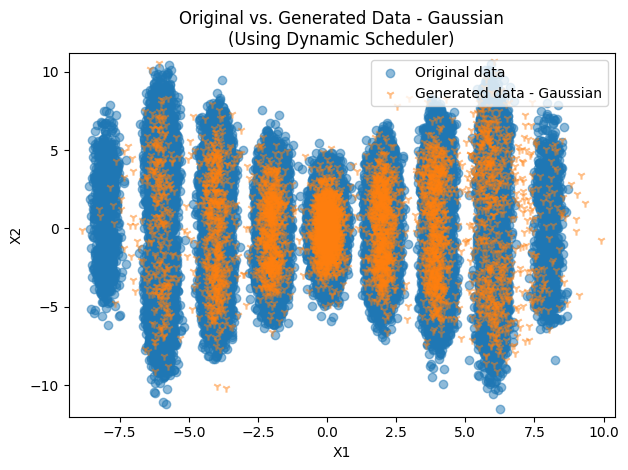

In [ ]:
cosine_alphas, cosine_baralphas, cosine_betas = cosine_schedule(diffusion_steps)
noiser = Noiser(cosine_baralphas,cosine_betas,cosine_alphas,phi_start,phi_end,theta_0)
Xgen, _ = sample_ddpm(models_dynamic,  5000, 2,noiser, "gussian",diffusion_steps=40)
Xgen=Xgen.cpu()

plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label="Original data")
plt.scatter(Xgen[:, 0], Xgen[:, 1], marker="1", alpha=0.5, label="Generated data - Gaussian")

plt.title("Original vs. Generated Data - Gaussian\n(Using Dynamic Scheduler)")
plt.legend(loc='upper right')
plt.xlabel("X1")
plt.ylabel("X2")

plt.xlim(min(X[:, 0].min(), Xgen[:, 0].min()) - 0.5, max(X[:, 0].max(), Xgen[:, 0].max()) + 0.5)
plt.ylim(min(X[:, 1].min(), Xgen[:, 1].min()) - 0.5, max(X[:, 1].max(), Xgen[:, 1].max()) + 0.5)

plt.tight_layout()
plt.show()

The results appear promising when evaluated visually. Additionally, we will present the KL divergence as a quantitative measure for further assessment.

In [ ]:
#Compute  KDE of the generated data with the Dynamic scheduler
kde_generated = compute_kde(Xgen)

# Compute KL divergence between the original and generated KDEs
kl_div = kl_divergence_kde(kde_original, kde_generated, grid_samples)

# Append the new row to the DataFrame
new_row = pd.DataFrame([["Daynamic Cosine", "Gaussian", kl_div]], columns=df_results.columns)
df_results = pd.concat([df_results, new_row], ignore_index=True)

Present the relevant results

In [ ]:
df_results[
    (df_results["Scheduling Method"].isin(["Cosine", "Daynamic Cosine"])) &
    (df_results["Limit Distribution"] == "Gaussian")
]

,Scheduling Method,Limit Distribution,KL Divergence
1,Cosine,Gaussian,0.076514
6,Daynamic Cosine,Gaussian,0.069912


An improvement can be seen in the case of Dynamic Cosine compared to the method proposed in the article.
We note that while there are experiments where the non dynamic cosine demonstrates superior performance ,**the majority of our experiments** show that the proposed method consistently improves the results.
